# Сборный проект: HR-аналитика

**Описание исследования**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 


**Цель исследования**

Разработать решение, которое позволит HR-аналитикам оптимизировать управление персоналом.

**Задачи исследования**

1) построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2) построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Исходные данные**

**Для задачи №1 были предоставлены данные:**

- id — уникальный идентификатор сотрудника
- dept— отдел, в котором работает сотрудник
- level — уровень занимаемой должности
- workload — уровень загруженности сотрудника
- employment_years — длительность работы в компании (в годах)
- last_year_promo — показывает, было ли повышение за последний год
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель
- salary — ежемесячная зарплата сотрудника
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак



Тренировочная выборка:
`train_job_satisfaction_rate.csv`

Входные признаки тестовой выборки:
`test_features.csv`

Целевой признак тестовой выборки:
`test_target_job_satisfaction_rate.csv`


**Для задачи №2:**

- данные те же, что и описаны выше, только целевой признак будет quit - увольнение сотрудника из компании.

Тренировочная выборка:
`train_quit.csv`

Входные признаки тестовой выборки те же, что и в прошлой задаче:
`test_features.csv`

Целевой признак тестовой выборки:
`test_target_quit.csv`



## Задача №1

### Импорт библиотек, загрузка, чтение данных

In [1]:
!pip install -U scikit-learn -q

In [2]:
!pip install phik -q 
!pip install shap -q

#ИЛИ
# !pip install -r requirements.txt
# при необходимости можно запустить данную команду, для установки версий библиотек,
#которые использовались при использовании данного проекта
# и с которыми не возникали конфликты

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats 
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn import model_selection, metrics
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV
                                    )
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   MinMaxScaler,
                                   RobustScaler,
                                   PolynomialFeatures,
                                   LabelEncoder
                                  )
from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression
                                 )
from sklearn.metrics import (roc_auc_score,
                             make_scorer
                            )
from sklearn.feature_selection import (SelectKBest,
                                       f_classif
                                      )
from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor
                         )
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC
import phik
from phik.report import plot_correlation_matrix
from phik import report
from phik import phik_matrix
import shap

In [5]:
# Проведем импорт констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [6]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
try:
    test_features = pd.read_csv('/datasets/test_features.csv')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
try:
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


### Изучение данных

#### Датасет train_job_satisfaction_rate

In [9]:
train_job_satisfaction_rate.info()
train_job_satisfaction_rate.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [10]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Изучили датасет. В нем содержится 4000 записей. В датасете имеются пропуски в двух столбцах (они могли возникнуть в результате человеческого фактора или технических неполадок), как поступить с пропусками, решим на этапе предобработки данных. 

Типы данных всех столбцов соответствуют данным, что в них содержатся.
Если говорить об описательной статистике, то каких-то выбросов в данных не наблюдается, но точные выводы можно будет сделать только после исследовательского анализа.

Все столбцы имеют корректное наименование, соответствующее змеиному регистру, поэтому переименовывать столбцы на этапе предобработки данных не будем.

#### Датасет test_features

In [11]:
test_features.info()
test_features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [12]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Изучили датасет. В нем содержится 2000 записей. В датасете имеются пропуски в двух столбцах (они могли возникнуть в результате человеческого фактора или технических неполадок), как поступить с пропусками, решим на этапе предобработки данных. Стоит отметить, что количество пропусков отличается, отчего данные не совсем не совпадают с предыдущим датасетом.

Типы данных всех столбцов соответствуют данным, что в них содержатся. Если говорить об описательной статистике, то каких-то выбросов в данных не наблюдается, но точные выводы можно будет сделать только после исследовательского анализа.

Все столбцы имеют корректное наименование, соответствующее змеиному регистру, поэтому переименовывать столбцы на этапе предобработки данных не будем.

#### Датасет test_target_job_satisfaction_rate

In [13]:
test_target_job_satisfaction_rate.info()
test_target_job_satisfaction_rate.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [14]:
test_target_job_satisfaction_rate.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

Изучили датасет. В нем содержится 2000 записей. Пропуски отсутствуют.

Типы данных всех столбцов соответствуют данным, что в них содержатся. Если говорить об описательной статистике, то каких-то выбросов в данных не наблюдается, но точные выводы можно будет сделать только после исследовательского анализа.

Все столбцы имеют корректное наименование, соответствующее змеиному регистру, поэтому переименовывать столбцы на этапе предобработки данных не будем.

### Предобработка данных

Так как менять названия столбцов, тип данных не нужно, перейдём к следующим этапам предобработки:

In [15]:
print('Число дублей в датафрейме train_job_satisfaction_rate:', train_job_satisfaction_rate.duplicated().sum())
print('Число дублей в датафрейме test_features:', test_features.duplicated().sum())
print('Число дублей в датафрейме test_target_job_satisfaction_rate:', test_target_job_satisfaction_rate.duplicated().sum())

Число дублей в датафрейме train_job_satisfaction_rate: 0
Число дублей в датафрейме test_features: 0
Число дублей в датафрейме test_target_job_satisfaction_rate: 0


Явных дубликатов нет в датасетах, проверим наличие неявных дубликатов:

In [16]:
# Обозначим список, где имеются категориальные столбцы
dataframes = [train_job_satisfaction_rate, test_features]

In [17]:
# создадим цикл, который будет перебирать уникальные значения категориальных столбцов датасетов
# также сделаем разделение датасетов
for i, df in enumerate(dataframes):
    print(f"\nДатасет {i+1}:\n")
    
    for column in df.select_dtypes(include=['object']).columns:
        print(f"Уникальные значения для {column}:")
        unique_values = df[column].unique()
        print(", ".join(map(str, unique_values)))
        print() 



Датасет 1:

Уникальные значения для dept:
sales, hr, technology, purchasing, marketing, nan

Уникальные значения для level:
junior, middle, sinior, nan

Уникальные значения для workload:
medium, high, low

Уникальные значения для last_year_promo:
no, yes

Уникальные значения для last_year_violations:
no, yes


Датасет 2:

Уникальные значения для dept:
marketing, hr, sales, purchasing, technology, nan,  

Уникальные значения для level:
junior, middle, sinior, nan

Уникальные значения для workload:
medium, low, high,  

Уникальные значения для last_year_promo:
no, yes

Уникальные значения для last_year_violations:
no, yes



Неявных дубликатов и неявных дубликатов, возникших из-за опечаток в датасетах нет. Однако присутствует орфографическая ошибка в названии грейда. Хочется её исправить

In [18]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior','senior')
test_features['level'] = test_features['level'].replace('sinior','senior')

In [19]:
# Проверим, исправилась ли орфографическая ошибка
list(train_job_satisfaction_rate['level'].unique())

['junior', 'middle', 'senior', nan]

In [20]:
list(test_features['level'].unique())

['junior', 'middle', 'senior', nan]

Произвели проверку дубликатов. Изучим пропущенные значения:

In [21]:
# Выведем все строки с пропущенными значениями в датасете train_job_satisfaction_rate
train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isnull() | train_job_satisfaction_rate['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [22]:
# Выведем все строки с пропущенными значениями в датасете train_job_satisfaction_rate
test_features[test_features['dept'].isnull() | test_features['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Так как пропуски у столбцов, которые имеют категориальный признак, и уникальных значений их немного, и, скорее всего, закономерности возникновения пропусков нет (например, просто кто-то не сообщал информацию о себе преднамеренно (в таком случае могут быть искажения при заполнении пропусков)), то мы можем заменить эти значения модой или иначе самым распространённым. Сделаем это с помощью пайплайна:

In [23]:
# Заменим пропущенные значения с помощью соответствующего пайплайна на наиболее распространенные
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [24]:
# Обработаем пропущенные значения датасета train_job_satisfaction_rate при помощи пайплайна
nan_cols = ['dept', 'level']
#Обучение пайплайна
imputer_pipe.fit(train_job_satisfaction_rate[nan_cols])

train_job_satisfaction_rate[nan_cols] = imputer_pipe.transform(train_job_satisfaction_rate[nan_cols])
test_features[nan_cols] = imputer_pipe.transform(test_features[nan_cols])

# Проверка на тренировочной выборке
display(train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isnull() | train_job_satisfaction_rate['level'].isnull()])
print(f'Количество пропущенных значений после замены в train_job_satisfaction_rate: \n {train_job_satisfaction_rate.isna().sum()}')

# Проверка на тестовой выборке
display(test_features[test_features['dept'].isnull() | test_features['level'].isnull()])
print(f'Количество пропущенных значений после замены в test_features: \n {test_features.isna().sum()}')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Количество пропущенных значений после замены в train_job_satisfaction_rate: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


Количество пропущенных значений после замены в test_features: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


**Вывод по предобработке данных**:

 + в результате изучения данных было установлено, что все столбцы не требовали корректировки названия, так как уже были названы в соответствии со змеиным регистром;
 
 + был проверен тип данных: все типы данных также соответствуют данным, которые заявлены в датасете, поэтому этот шаг также был пропущен и было решено перейти к проверке дубликатов и обработке пропусков;
 
 + произвели проверку явных дубликатов. во всех представленных датасетах явных дубликатов не было обнаружено, однако нужно провести проверку и неявных дубликатов тоже. проверка показала, что неявных дубликатов в датасетах нет, однако в двух датасетах была обнаружена орфографическая ошибка в названии грейда 'senior', которую исправили. (в датасетах test_features и train_job_satisfaction_rate
 
 + в датасетах, названных выше также были обнаружены пропуски. было решено заменить их (nan) наиболее распространенными значениями с помощью пайплайна, проверка показала, что пропуски были заполнены.

 
 Можем переходить к исследовательскому анализу.

### Исследовательский анализ данных

Построим гистограммы по непрерывным количественным признакам, чтобы сопоставить с данными, полученными после описательной статистики. 



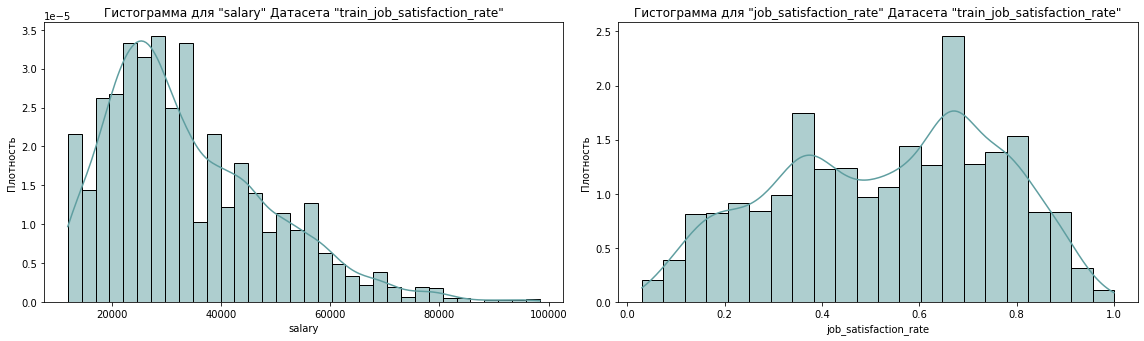

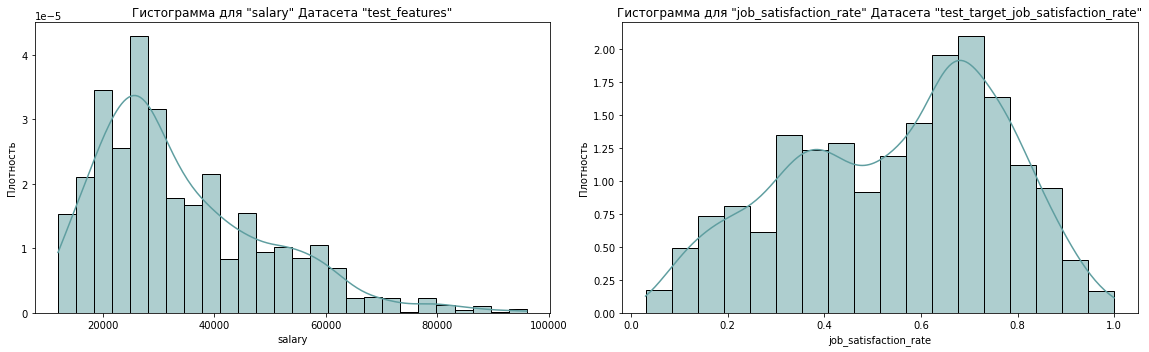

In [25]:
continuous_cols = ['salary', 'job_satisfaction_rate']

fig, axes = plt.subplots(1, 2, figsize=(16,5))  

for i, col in enumerate(continuous_cols):
    sns.histplot(
        train_job_satisfaction_rate[col],
        stat='density',
        common_norm=False,
        kde=True,
        color='cadetblue',
        ec='black',
        ax=axes[i] 
    )
    axes[i].set_title(f'Гистограмма для "{col}" Датасета "train_job_satisfaction_rate"')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Плотность')

plt.tight_layout()  
plt.show()

# Сопоставим тренировочную выборку с тестовой 
# Объявим функцию, которая будет строить гистограммы
def plot_histogram(data, feature, ax, title):
    sns.histplot(
        data[feature],
        stat='density',
        common_norm=False,
        kde=True,
        color='cadetblue',
        ec='black',
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel('Плотность')


fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_histogram(test_features, 'salary', axes[0], 'Гистограмма для "salary" Датасета "test_features"')
plot_histogram(test_target_job_satisfaction_rate, 'job_satisfaction_rate', axes[1], 'Гистограмма для "job_satisfaction_rate" Датасета "test_target_job_satisfaction_rate"')

plt.tight_layout()
plt.show()

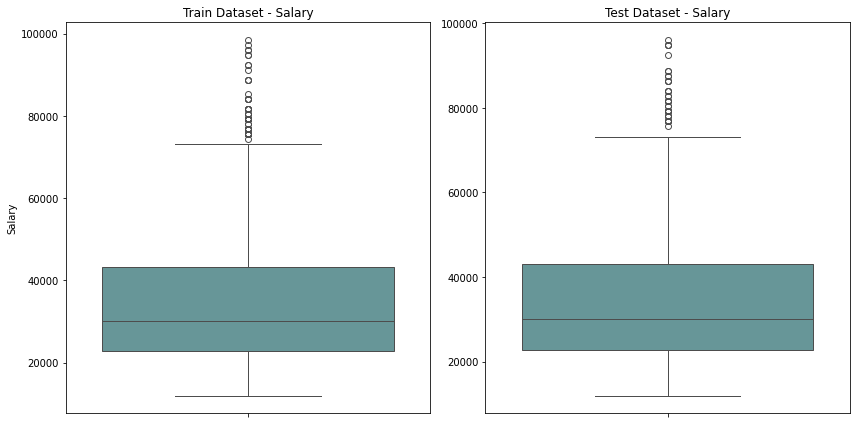

In [26]:
def plot_salary_boxplot(train_df, test_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Boxplot для 'salary' 
    sns.boxplot(data=train_df, y='salary', ax=axes[0], color='cadetblue')
    axes[0].set_title('Train Dataset - Salary')
    axes[0].set_ylabel('Salary')
    
    # Boxplot для 'salary' test_features
    sns.boxplot(data=test_df, y='salary', ax=axes[1], color='cadetblue')
    axes[1].set_title('Test Dataset - Salary')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

plot_salary_boxplot(train_job_satisfaction_rate, test_features)


Видны выбросы, но мы их удалять не будем.

Согласно описательной статистике, казалось, что непрерывные количественные признаки распределены равномерно. Но при построении графиков можно увидеть, что это не совсем так:в ежемесячной зарплате сотрудников имеется сдвиг влево,а если смотреть на уровень удовлетворенности, можно увидеть небольшой сдвиг вправо. При сравнении с тестовой выборкой, можно заметить, что распределение примерно одинаковое, но разный масштаб данных. Можно сделать вывод, что необходимо масштабирование.



Построим гистограммы для дискретных признаков:

In [27]:
discrete_cols = ['employment_years', 'supervisor_evaluation']

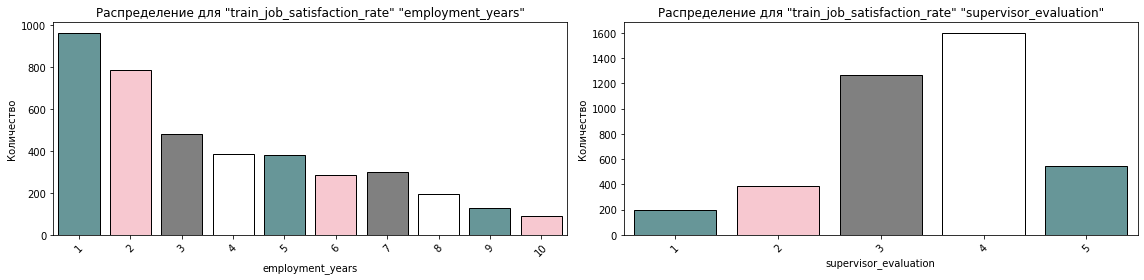

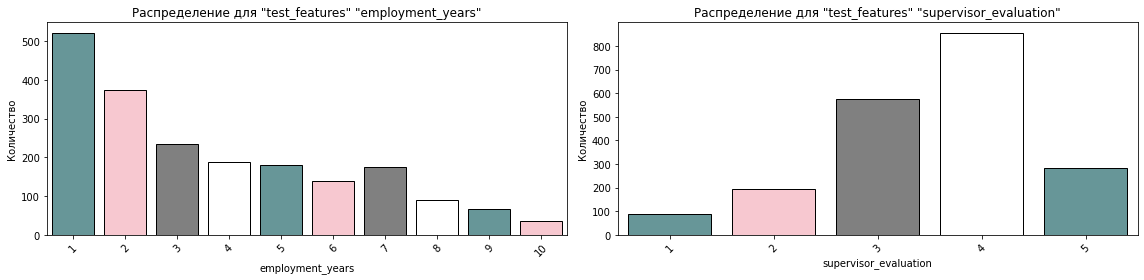

In [28]:
#Для построения объявим следующую функцию, которая будет строить данные по дискретным признакам:
def plot_discrete_counts(data, columns, title_prefix):
    fig, axes = plt.subplots(1, len(columns), figsize=(16, 4))  
    for i, column in enumerate(columns):
        sns.countplot(
            data=data,
            x=column,
            palette=['cadetblue', 'pink', 'grey', 'white'],
            ec='black',
            ax=axes[i]  
        )
        axes[i].set_title(f'{title_prefix} "{column}"')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Количество')
        axes[i].tick_params(axis='x', rotation=45)  

    plt.tight_layout()
    plt.show()

plot_discrete_counts(train_job_satisfaction_rate, discrete_cols, 'Распределение для "train_job_satisfaction_rate"')
plot_discrete_counts(test_features, discrete_cols, 'Распределение для "test_features"')

На основании построенных графиков можно сделать вывод, что преобладающее количество сотрудников в организации работают меньше 1 года или год. Скорее всего, это молодые специалисты, имеющие начальный грейд - Джуниор.

Оценки, которые ставит руководитель, как правило, средние (4 и 3 - скорее всего, для сотрудников, работаюших меньше двух лет, 5 - очень редко, может это соответствует распределению категориального признака 'level', проверим дальше). Возможно, из-за недостаточного опыта сотрудников.
Опять же видно, что распределение примерно одинаковое, но снова разный масштаб данных, поэтому эти признаки также необходимо масштабировать.


**Изучим категориальные признаки.**


Определим функцию, которая будет строить столбчатые диаграммы для категориальных признаков (для тестовой и тренировочной выборки), чтобы мы могли сравнить и сделать выводы по построенным графикам.

In [29]:
def to_barplot(df, df1, title):
    # Получение всех столбцов с типом object
    object_cols = df.select_dtypes(include='object').columns.tolist()
    
    def plot_single_bar(data, axis, dataset_title, column):
        counts = data.pivot_table(index=column, values='id', aggfunc='count')
        counts['percent'] = counts['id'] / counts['id'].sum() * 100
        
        # Построение столбчатой диаграммы
        sns.barplot(x=counts.index, y=counts['percent'], ax=axis, palette='coolwarm', ec='black')
        axis.set_title(f"{title} - {column} ({dataset_title})")
        axis.set_xlabel(column)
        axis.set_ylabel('Процент')
        
        # Добавление процентных меток
        for p in axis.patches:
            axis.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', xytext=(0, 8), textcoords='offset points')
    
    for column in object_cols:
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        
        plot_single_bar(df, axes[0], "Train Dataset", column)
        plot_single_bar(df1.loc[df1[column] != ' '], axes[1], "Test Dataset", column)
        
        plt.tight_layout()
        plt.show()

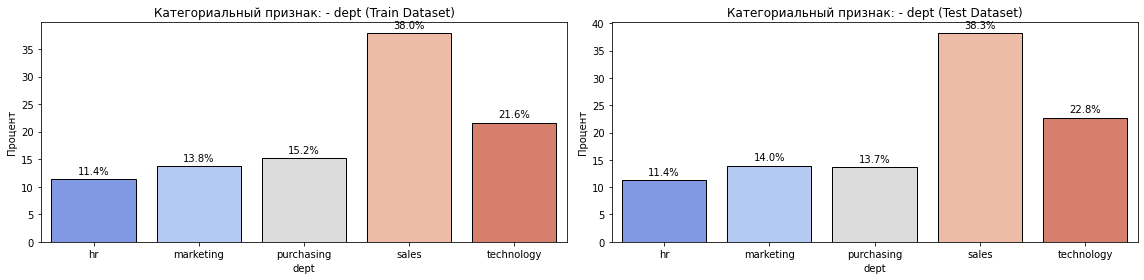

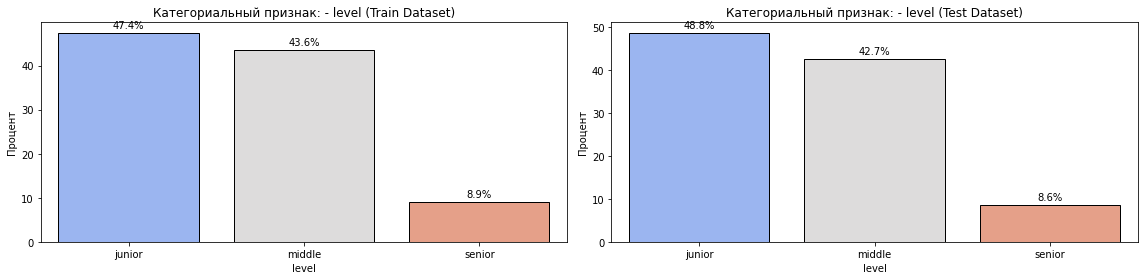

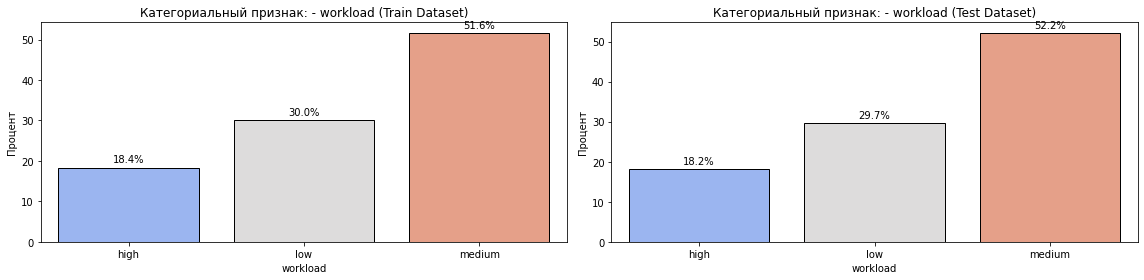

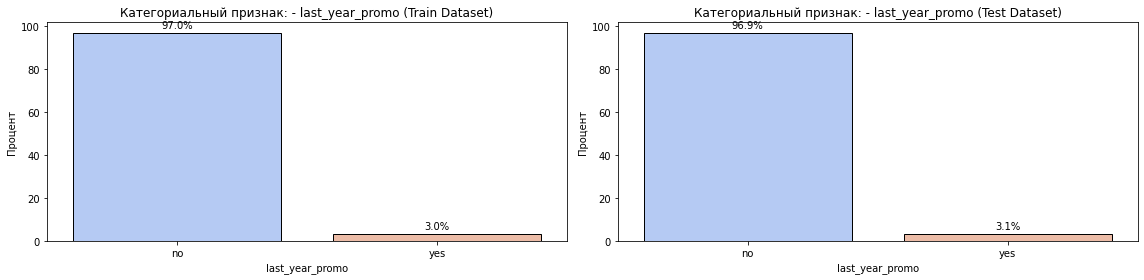

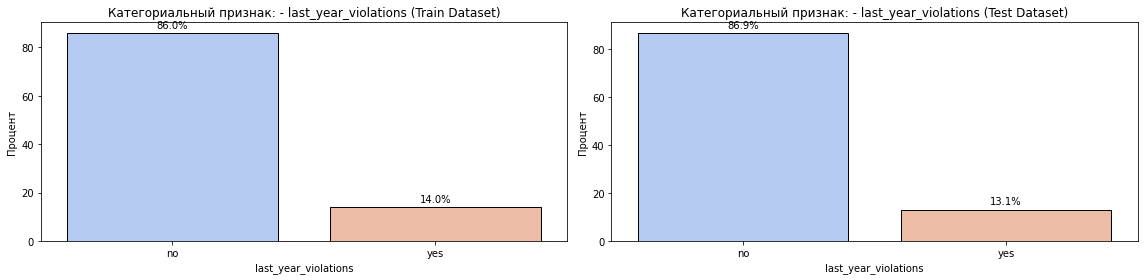

In [30]:
to_barplot(train_job_satisfaction_rate, test_features, title='Категориальный признак:')

На основании построенных графиком можно сделать вывод, что больше всего в компании сотрудников, работающих в отделе продаж, сотрудников с грейдом senior мало, сильно преобладают две остальные категории, что в принципе мы уже указали в выводах при построении количественных признаков.

Больше всего сотрудников со средним уровнем загруженности. Повышения в компании практически никто не получал (97%). Наверное, поэтому больше джунов.

Нарушения трудового договора выявлены у 14% сотрудников.

Для подготовки категориальных признаков прибегнем к кодированию. Для повышение и нарушение ТД, отделов можно использовать OneHotEncoder, для остальные OrdinalEncoder.

### Построение матрицы корреляции

In [31]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

train_job_satisfaction_rate.info()

#сделали этот шаг, чтобы не учитывать столбец id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


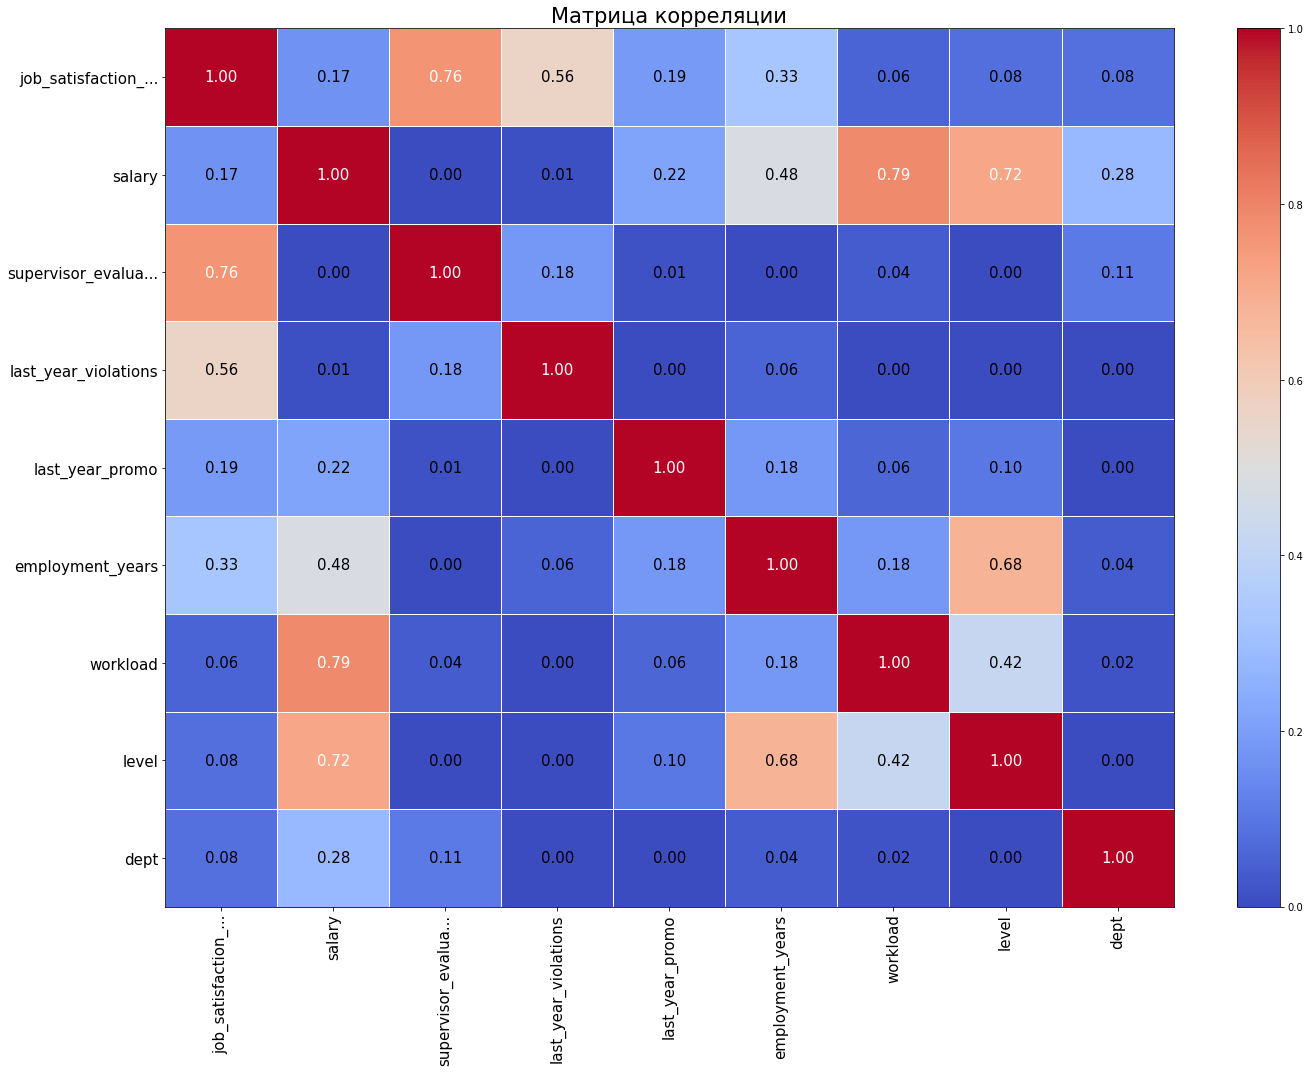

In [32]:
interval_cols = ['salary', 'job_satisfaction_rate']
corr_matrix = phik_matrix(train_job_satisfaction_rate, interval_cols=interval_cols)


plot_correlation_matrix(
    corr_matrix.values,
    x_labels = corr_matrix.columns,
    y_labels = corr_matrix.index,
    vmin = 0, vmax = 1, color_map = 'coolwarm',
    title='Матрица корреляции',
    fontsize_factor=1.5,
    figsize=(20, 15)
)


**Вывод:**

По матрице корреляции можно сделать следующий вывод:
Данные выглядят достоверно, выбросов нет критических, утечки целевого признака нет.


Обучение будем проводить с подготовкой данных в пайплане.

### Подготовка данных

 
`dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder, так как здесь нет порядка значений или градации, просто будем кодировать категориальные признаки.

`level`, `workload` — нужно кодировать с помощью OrdinalEncoder, так как здесь есть "градация", порядок значений (в сторону увеличения)

`employment_years`, `supervisor_evaluation`, `salary` - нужно масштабировать, так как на графиках сравнения тренировочной и тестовой выборки были выявлены разные масштабы данных.


Целевой признак — `job_satisfaction_rate`. задачу мультиклассовой классификации тут рассматривать не будем.

In [33]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [34]:
#Объединили датасеты 
train_job_satisfaction_rate = test_features.merge(test_target_job_satisfaction_rate, on='id').set_index('id')

train_job_satisfaction_rate.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2000 non-null   object 
 1   level                  2000 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


id мы не удалили, но учитываться он в модели не будет. при необходимости мы сможем к нему обратиться через index, вообще не желательно удалять всё, так как мы можем лишиться данных, на которых модель учится.

Проведем еще одно объединение, для образования тестовой выборки

In [35]:
test_features_task_1 = test_features.merge(test_target_job_satisfaction_rate, on='id').set_index('id')

In [36]:
# Выделим целевой признак и проведем разделение выборки на тренировочную и тестовую. 
# Константы импортировали ранее, поэтому здесь они не фигурируют

X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)  
y_train = train_job_satisfaction_rate['job_satisfaction_rate']                 # Целевая переменная тренировочной выборки
X_test = test_features_task_1.drop(['job_satisfaction_rate'], axis=1)                 # Целевая переменная тестовой выборки
y_test = test_features_task_1['job_satisfaction_rate']
X_train.shape


(2000, 8)

In [37]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation']

In [38]:
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Cоздаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
     ],
    remainder='passthrough'
)

# Cоздаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Обучение моделей

Таким образом, провели подготовку данных (кодирование, масштабирование) с использованием пайплайна.


ОБУЧЕНИЕ МОДЕЛИ:

In [39]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 11),
        'models__max_features': range(5, 11)
    },
 
    {
        'models': [LinearRegression()]
    }
]

СОЗДАНИЕ МЕТРИКИ SMAPE

In [40]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2))

# Создаем метрику с make_scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

In [41]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_violations',
                                                                          'last_year_promo',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[['junior',
                                                                                                                      'middle',
                                                                                                                      's...
                                                                         StandardScaler(),
                                                                         ['salary',
                                                                          'employment_years',
                                                                          'supervisor_evaluation'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 11),
                          'models__max_features': range(5, 11)},
                         {'models': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [42]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                              

In [43]:
y_pred_test = grid.best_estimator_.predict(X_test)
smape_value = smape(y_test, y_pred_test)
print("Метрика SMAPE на тренировочной выборке равна:", smape_value)

Метрика SMAPE на тренировочной выборке равна: 10.796197710303153


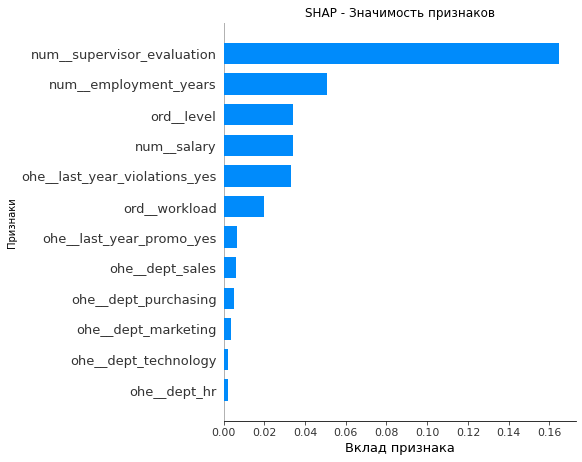

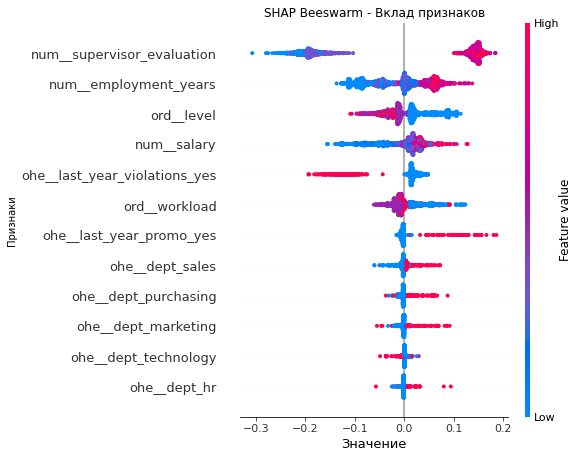

In [44]:
# Преобразуем данные с помощью пайплайна
X_train_preprocessed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_preprocessed = pipe_final.named_steps['preprocessor'].transform(X_test)


explainer = shap.TreeExplainer(grid.best_estimator_.named_steps['models'])
shap_values = explainer.shap_values(X_test_preprocessed, check_additivity=False)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Построение bar графика для SHAP значений
shap.summary_plot(shap_values, X_test_preprocessed_df, plot_type="bar", max_display=30, show=False)
plt.title('SHAP - Значимость признаков')
plt.xlabel("Вклад признака")
plt.ylabel("Признаки")
plt.show()

# Построение beeswarm графика для SHAP значений
shap.summary_plot(shap_values, X_test_preprocessed_df, plot_type="dot", max_display=30, show=False)
plt.title('SHAP Beeswarm - Вклад признаков')
plt.xlabel("Значение")
plt.ylabel("Признаки")
plt.show()



Для признака Оценка руководителя есть высокие значения в правой части графика. То есть как раз можем сделать вывод, что высокие оценки от руководителя способствуют более высокому уровню удовлетворенности.
Признак Годы работы имеет смешанный эффект, но можно заметить, что низкие значения (синие) в основном располагаются слева от центра, что указывает на снижение уровня удовлетворенности для сотрудников с меньшим стажем.


### Выводы по задаче №1

На данном шаге исследования была найдена и обучена модель для предсказания уровня удовлетворенности сотрудников компании.

Лучшие результаты показала модель DecisionTreeRegressor (Дерево решений) (max_depth=10 (макс.глубина), max_features=10 (максимальное число признаков), random_state=42))]) 
Выбирали модель на основе данных, полученных от метрики SMAPE(Symmetric Mean Absolute Percentage Error) — это метрика, которая позволяет сравнивать величину ошибки в прогнозировании с фактическими значениями, выражая её в процентах. SMAPE обладает симметричностью, что означает, что она одинаково наказывает за переоценку и недооценку. 

Этот подход особенно полезен, когда значения целевой переменной могут меняться в большом диапазоне, что применимо к нашему признаку.


- метрика `SMAPE` лучшей модели на тренировочной выборке составила: 16.96, а для тестовой: 10.79

Значение SMAPE на тестовой выборке меньше, чем на тренировочной, что может быть признаком того, что модель лучше справляется с предсказанием на тестовых данных. А также полученный результат соответствует требованиям проекта (меньше или равно 15)

А также провели Анализ признаков, которые имеют наибольший вклад в прогноз модели. Получился интересный результат, так как казалось бы, на первом месте должна быть зарплата. Но тут получается, что топ 5:

- Оценка руководителя - возможно, для некоторых сотрудников, особенно молодых с небольшим опытом, это может быть мотивацией и если они получают хорошую оценку руководителя, то они более удовлетворенные, или наоборот от низких оценок падает удовлетворенность

- Годы работы

- Зарплата

- Грейд

- Были ли нарушения ТД

В принципе, с данным топом согласиться можно, но я бы еще предположила, что наличие повышения также имеет влияние.(но далее мы можем увидеть, что данный признак не последний в списке).


## Задача №2

### Импорт библиотек, загрузка, чтение данных

In [45]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [46]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [47]:
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
    
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


### Изучение данных

**Датасет train_quit**

In [48]:
# Выведем информацию о данных в датасете и приведем описательную статистику
train_quit.info()
train_quit.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [49]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Изучили датасет. В нем содержится 4000 записей. В датасете пропуски отсутствуют. Типы данных всех столбцов соответствуют представленным данным.
Все столбцы имеют корректное наименование, соответствующее змеиному регистру, переименовывать столбцы не будем.

Если говорить об описательной статистике, то ее результаты демонстрируют нормальную картину данных, каких-то выбросов нет, но более точно сможем сделать вывод только на этапе Исследовательского анализа.

**Датасет test_features**

В принципе, информацию по данному датасету мы уже изучали в предыдущей задаче, но давайте выведем информацию


In [50]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


С данными всё в порядке, в результате предобработки с использованием пайплайна пропусков нет.

**Датасет test_target_quit**

Описательную статистику смотреть не будем, так как для столбца id это не имеет смысла, а целевой поизнак - категориальный

In [51]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [52]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

Изучили датасет, в нем содержится 2000 записей. Пропусков в датасете нет, типы данных столбцов соответствуют. Описательную статистику не проводили, так как целевой признак категориальный, а для id это бесполезно.
Все столбцы имеют корректное наименование (соответ. змеиному регистру), переименовывать не будем.

Проведем проверку дубликатов (у test_features явные дубликаты отсутствуют, орфографичнскую ошибку в прошлой задаче исправили):


In [53]:
print('Число дублей в датафрейме train_quit:', train_quit.duplicated().sum())
print('Число дублей в датафрейме test_features:', test_features.duplicated().sum())
print('Число дублей в датафрейме test_target_quit:', test_target_quit.duplicated().sum())

Число дублей в датафрейме train_quit: 0
Число дублей в датафрейме test_features: 0
Число дублей в датафрейме test_target_quit: 0


Явные дубликаты во всех датасетах отстутствуют.

Проверим неявные дубликаты:


In [54]:
# Обозначим список, где имеются категориальные столбцы
dataframes_second = [train_quit, test_features]

In [55]:
# создадим цикл, который будет перебирать уникальные значения категориальных столбцов датасетов
# также сделаем разделение датасетов
for i, df in enumerate(dataframes_second):
    print(f"\nДатасет {i+1}:\n")
    
    for column in df.select_dtypes(include=['object']).columns:
        print(f"Уникальные значения для {column}:")
        unique_values = df[column].unique()
        print(", ".join(map(str, unique_values)))
        print() 


Датасет 1:

Уникальные значения для dept:
sales, purchasing, marketing, technology, hr

Уникальные значения для level:
middle, junior, sinior

Уникальные значения для workload:
high, medium, low

Уникальные значения для last_year_promo:
no, yes

Уникальные значения для last_year_violations:
no, yes

Уникальные значения для quit:
no, yes


Датасет 2:

Уникальные значения для dept:
marketing, hr, sales, purchasing, technology,  

Уникальные значения для level:
junior, middle, senior

Уникальные значения для workload:
medium, low, high,  

Уникальные значения для last_year_promo:
no, yes

Уникальные значения для last_year_violations:
no, yes



Если посмотреть уникальные значения, то неявных дубликатов нет, однако есть та же орфографическая ошибка, которую мы исправили в test_features, поэтому исправим в первом датасете тоже

In [56]:
train_quit['level'] = train_quit['level'].replace('sinior','senior')
train_quit['level'].sort_values().unique()

array(['junior', 'middle', 'senior'], dtype=object)

Успешно исправили ошибку в значении. 

**Общий вывод по предобработке данных**

- все столбцы имеют корректные названия в соответствии со змеиным регистром и не требуют переименования

- все типы данных также соответствуют

- пропусков в датасетах нет, явных дубликатов тоже, неявных нет, однако имеется орфографическая ошибка в одном из значений столбца level в датасете train_quit, ее исправили.


Можем переходить к исследовательскому анализу.

### Исследовательский анализ данных

Так как все количественные (дискретные и непрервыне) и категориальные признаки изучены в шаге Исследовательский анализ в рамках задачи №1 [26]-[29], то изучим новые признаки, которые были добавлены:

Категориальный признак 'quit'.


Сравним в тренировочной выборке (train_quit) и тестовой (test_target_quit)

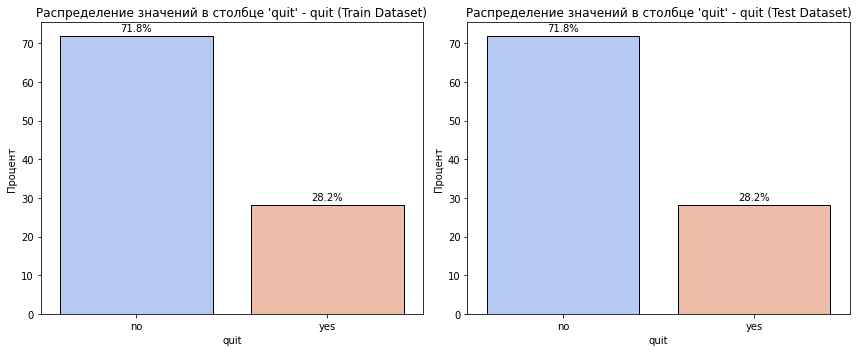

In [57]:
def to_barplot_quit(df_train, df_test, title):
    def plot_single_bar(data, axis, dataset_title):
        # Подсчёт количества и процентов для столбца 'quit'
        counts = data.pivot_table(index='quit', values='id', aggfunc='count')
        counts['percent'] = counts['id'] / counts['id'].sum() * 100
        
        sns.barplot(x=counts.index, y=counts['percent'], ax=axis, palette='coolwarm', ec='black')
        axis.set_title(f"{title} - quit ({dataset_title})")
        axis.set_xlabel('quit')
        axis.set_ylabel('Процент')
        
        for p in axis.patches:
            axis.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', xytext=(0, 8), textcoords='offset points')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Построение графиков для обучающего и тестового датасетов
    plot_single_bar(df_train, axes[0], "Train Dataset")
    plot_single_bar(df_test, axes[1], "Test Dataset")
    
    plt.tight_layout()
    plt.show()

to_barplot_quit(train_quit, test_target_quit, "Распределение значений в столбце 'quit'")


Видно, что соотношение в тренировочной и тестовой выборке одинаково.

Если говорить о дисбалансе значений целевого признака, то видно, что он присутствует. Нет преобладает над значением Да. 

Это может привести к тому, что обученная модель может ошибочно из-за такой статистики присвоить "Нет", там где должен быть "Да", могут смещаться метрики.. 

Изучим некоторые признаки, позволяющие составить портрет сотрудника, который мог бы уволиться, или уволился, в разрезе целевого признака

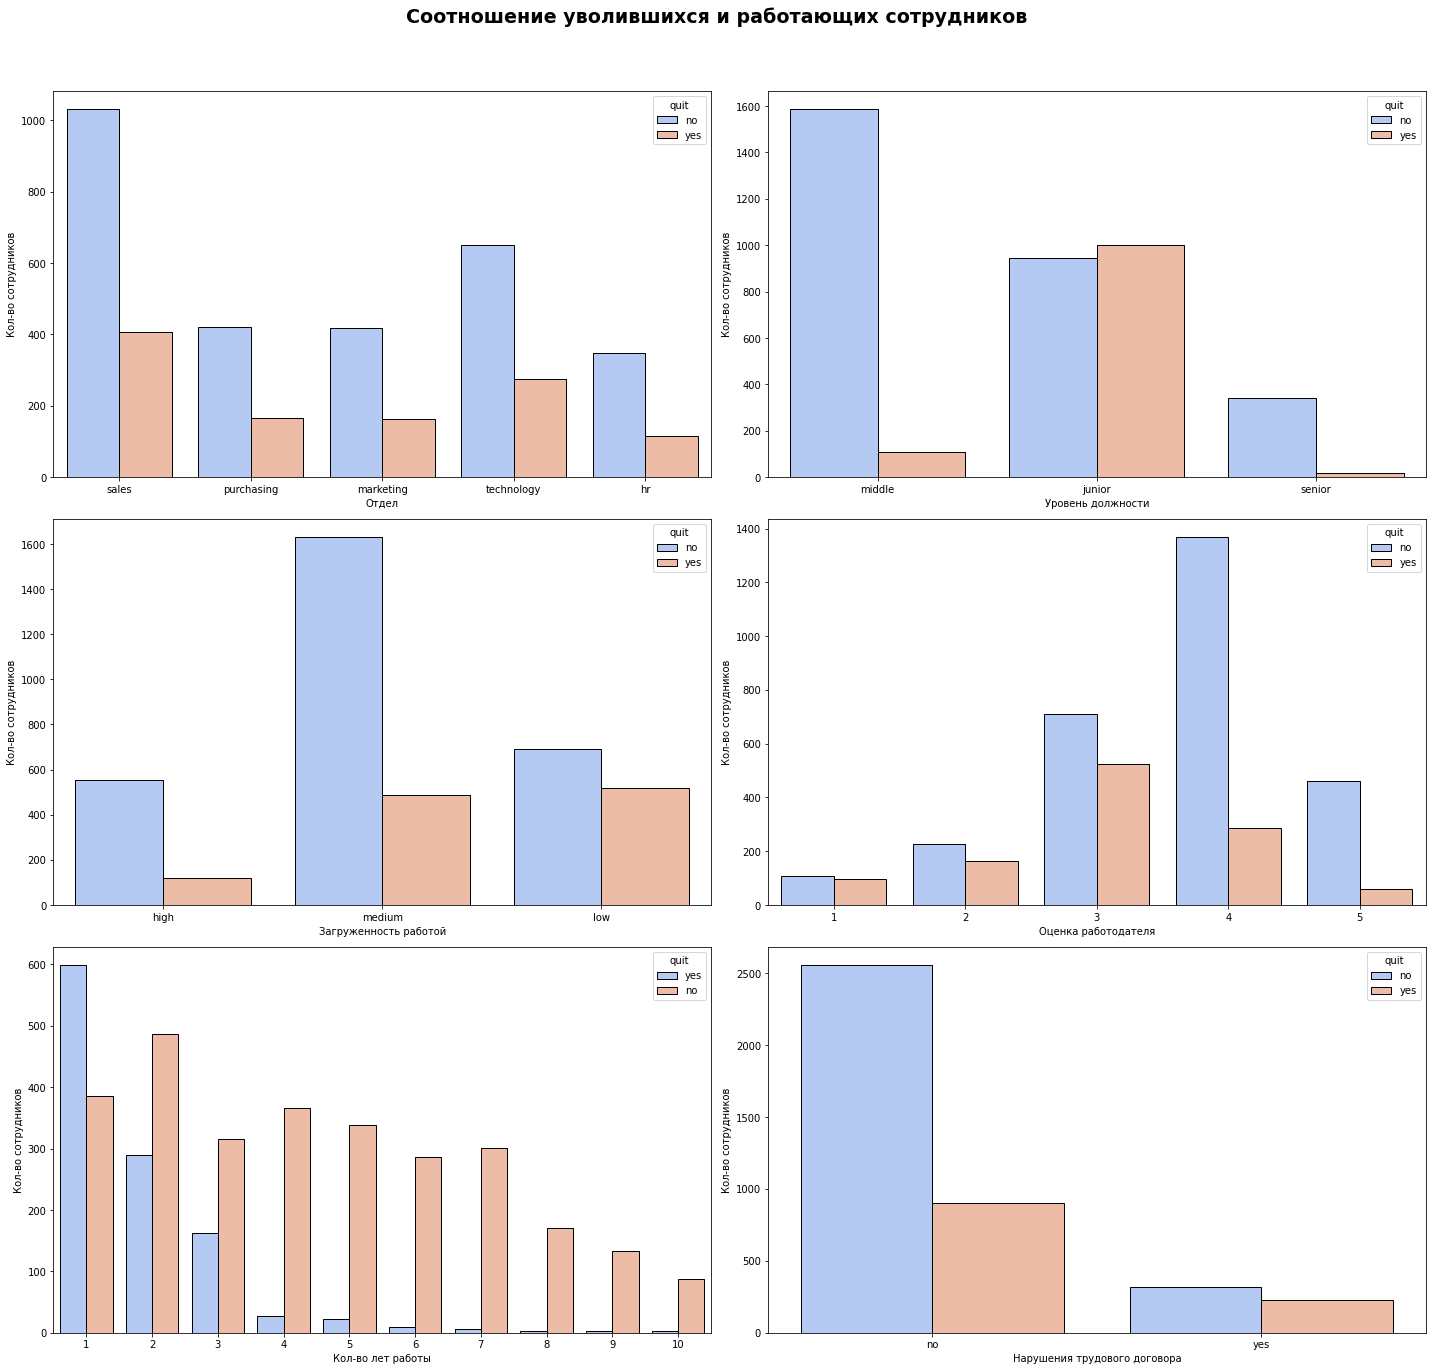

In [58]:
# Список признаков и подписей
features = ['dept', 'level', 'workload', 'supervisor_evaluation', 'employment_years', 'last_year_violations']
xlabels = ['Отдел', 'Уровень должности', 'Загруженность работой', 'Оценка работодателя', 'Кол-во лет работы', 'Нарушения трудового договора']

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')

# Цикл для построения countplot для каждого признака
for i, (feature, xlabel) in enumerate(zip(features, xlabels)):
    row, col = divmod(i, 2)  
    sns.countplot(x=feature, data=train_quit, hue='quit', palette="coolwarm", ec='black', ax=axes[row, col])
    axes[row, col].set(xlabel=xlabel, ylabel='Кол-во сотрудников')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Добавляем отступ под заголовок
plt.show()

In [59]:
categorical = train_quit.select_dtypes(exclude='number').columns.tolist()
categorical.extend(['supervisor_evaluation', 'employment_years'])
categorical


['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'quit',
 'supervisor_evaluation',
 'employment_years']

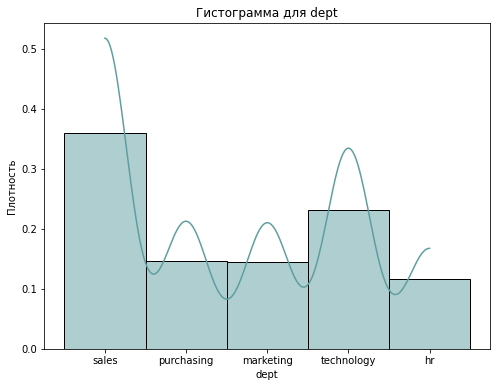

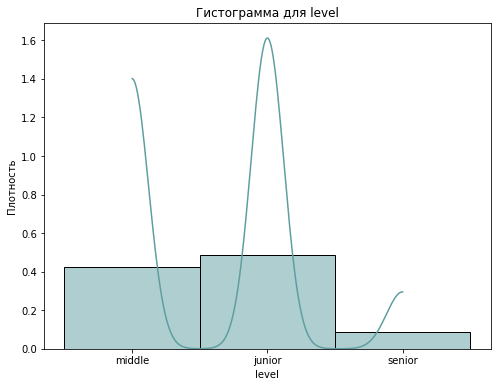

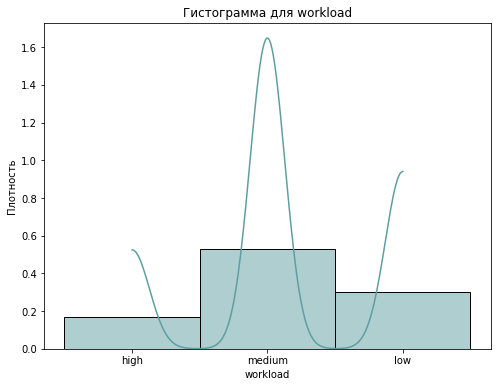

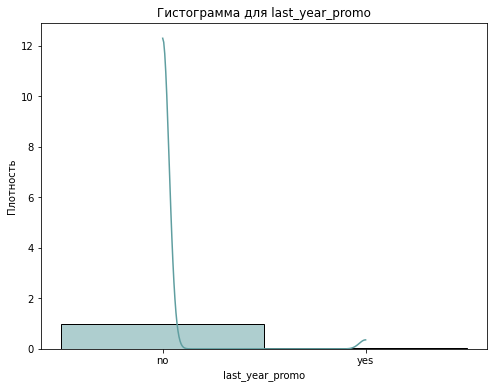

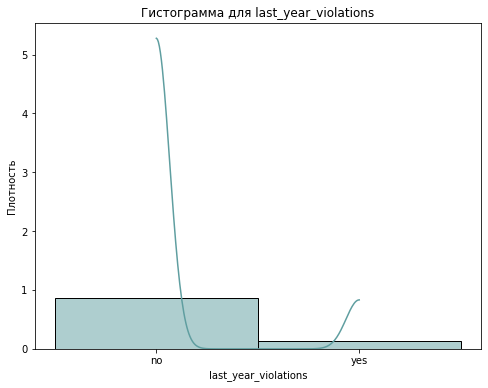

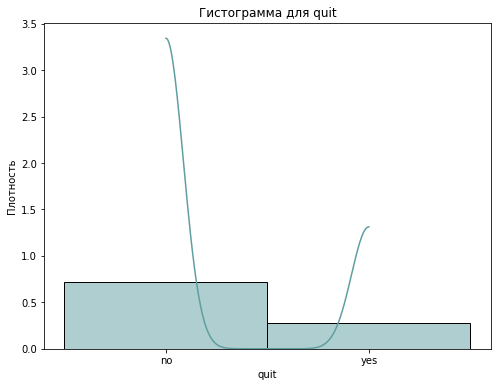

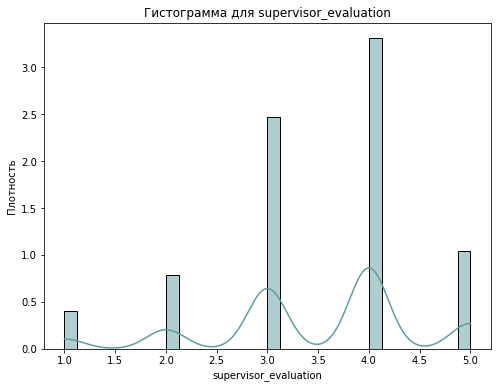

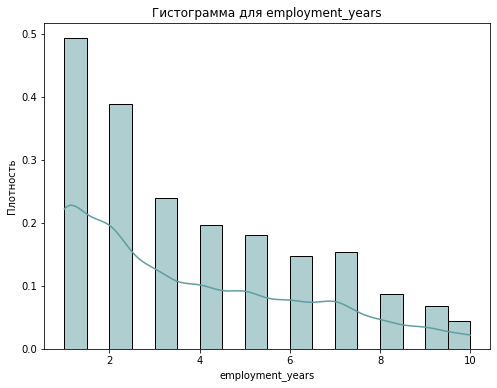

In [60]:
for col in categorical:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_quit[col], stat='density', common_norm=False, kde=True, color='cadetblue')
    plt.title(f'Гистограмма для {col}')
    plt.xlabel(col)
    plt.ylabel('Плотность')
    plt.show()

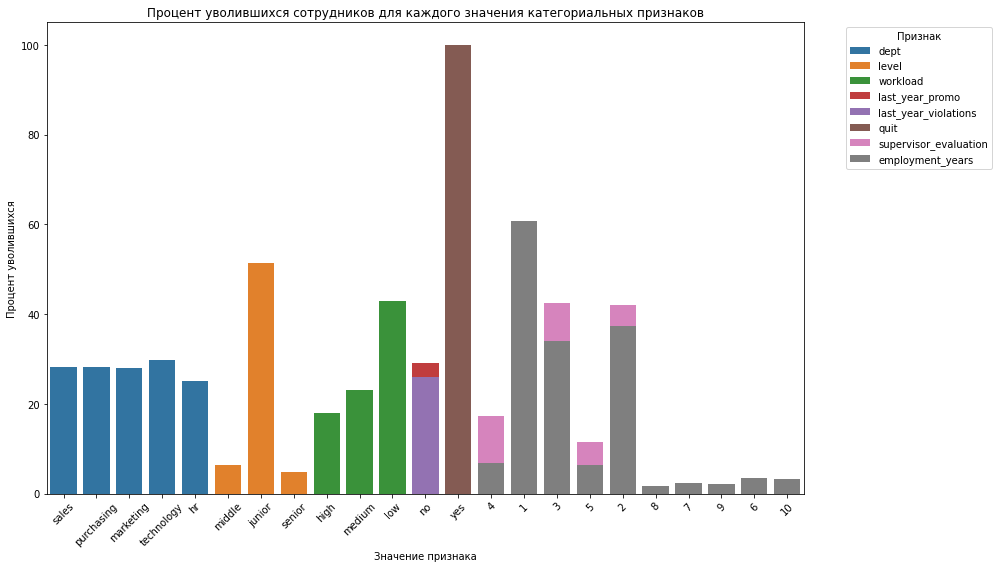

In [61]:
percentages = []

for i in categorical:
    for j in train_quit[i].unique():
        quit_count = train_quit[(train_quit[i] == j) & (train_quit['quit'] == 'yes')].shape[0]
        total_count = train_quit[train_quit[i] == j].shape[0]
        percentage = round(quit_count / total_count * 100, 2) if total_count > 0 else 0
        percentages.append({'Feature': i, 'Value': j, 'Quit Percentage': percentage})

# Создание датафрейма с рассчитанными процентами
percentages_df = pd.DataFrame(percentages)

# Построение графика
plt.figure(figsize=(14, 8))
sns.barplot(data=percentages_df, x='Value', y='Quit Percentage', hue='Feature', dodge=False)
plt.title('Процент уволившихся сотрудников для каждого значения категориальных признаков')
plt.xlabel('Значение признака')
plt.ylabel('Процент уволившихся')
plt.xticks(rotation=45)
plt.legend(title='Признак', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Здесь график, на котором можно увидеть группы столбцов по цветам и значение увольнений, далее приведу список процентов:

In [62]:
for i in categorical:
    
    for j in train_quit[i].unique():        
        print('Процент уволившихся сотрудников', i, j, round(train_quit[(train_quit[i] == j) & (train_quit['quit'] == 'yes')]\
                         .shape[0]/(train_quit[(train_quit[i] == j)].shape[0])*100,2), '%')
    print('*' * 125)

Процент уволившихся сотрудников dept sales 28.3 %
Процент уволившихся сотрудников dept purchasing 28.23 %
Процент уволившихся сотрудников dept marketing 28.01 %
Процент уволившихся сотрудников dept technology 29.74 %
Процент уволившихся сотрудников dept hr 25.0 %
*****************************************************************************************************************************
Процент уволившихся сотрудников level middle 6.38 %
Процент уволившихся сотрудников level junior 51.46 %
Процент уволившихся сотрудников level senior 4.76 %
*****************************************************************************************************************************
Процент уволившихся сотрудников workload high 17.95 %
Процент уволившихся сотрудников workload medium 23.04 %
Процент уволившихся сотрудников workload low 42.96 %
*****************************************************************************************************************************
Процент уволившихся сотрудников last_y

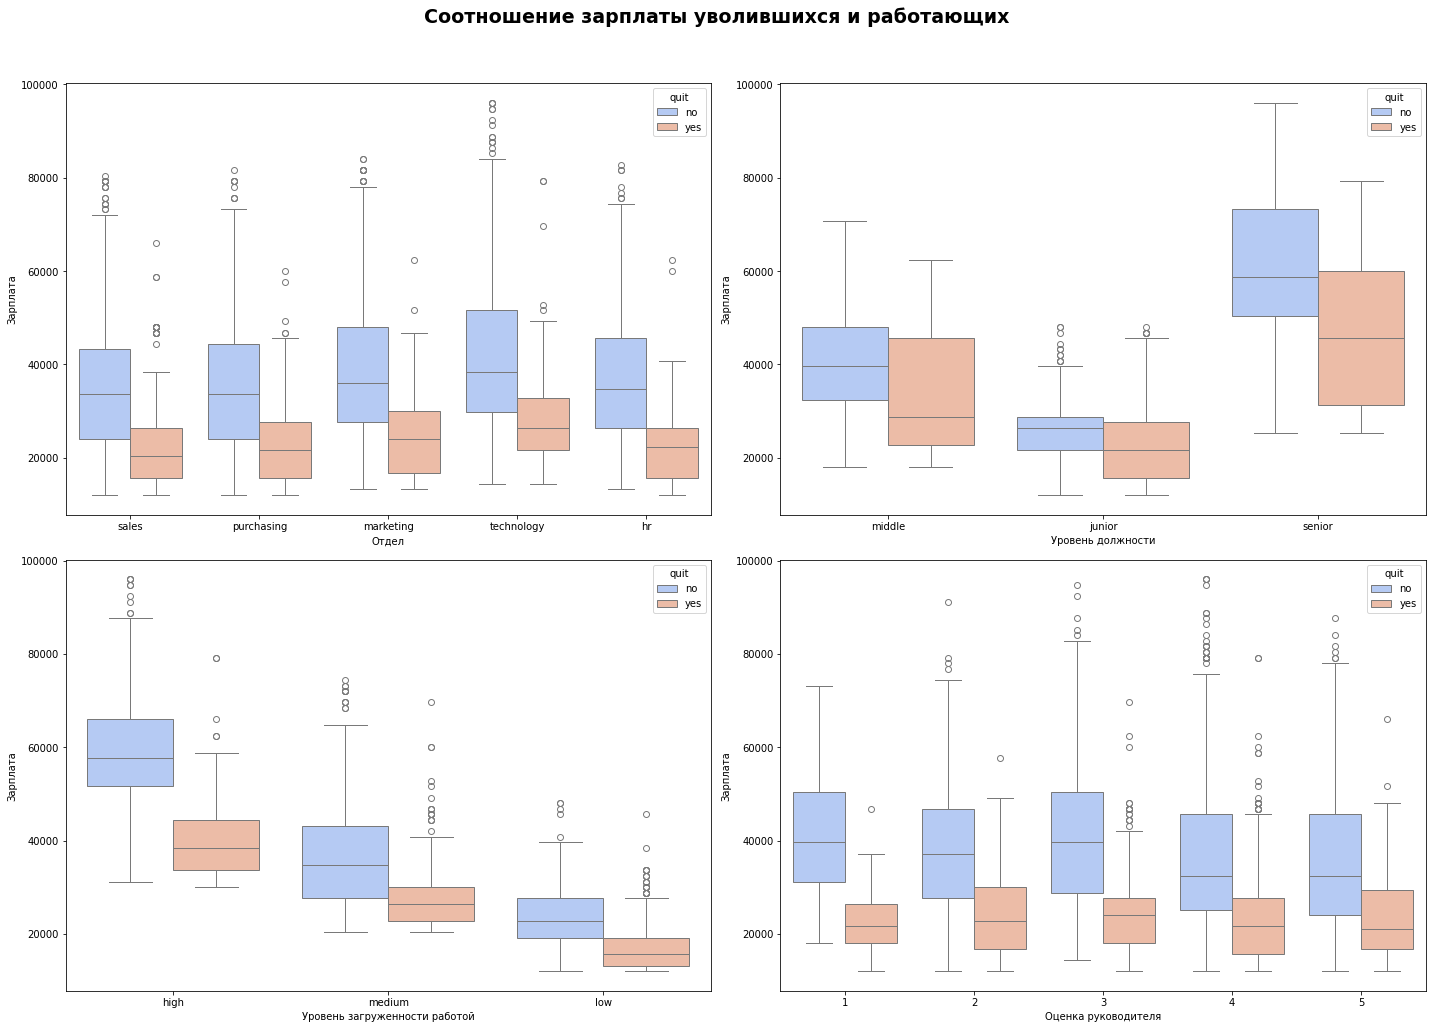

In [63]:
# Список признаков и подписей
features = ['dept', 'level', 'workload', 'supervisor_evaluation']
xlabels = ['Отдел', 'Уровень должности', 'Уровень загруженности работой', 'Оценка руководителя']


fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.suptitle('Соотношение зарплаты уволившихся и работающих', fontsize=19, fontweight='bold')

# Цикл для построения boxplot для каждого признака
for i, (feature, xlabel) in enumerate(zip(features, xlabels)):
    row, col = divmod(i, 2)  
    sns.boxplot(x=feature, y='salary', hue='quit', palette='coolwarm', data=train_quit, ax=axes[row, col])
    axes[row, col].set(xlabel=xlabel, ylabel='Зарплата')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Добавляем отступ под заголовок
plt.show()


Подведём итоги:

В отделе, где работает сотрудник, наблюдается высокая текучесть кадров. Если рассматривать абсолютные показатели, то большинство уволившихся сотрудников работали в отделе продаж. Однако если сравнивать относительные показатели, то наибольшее количество увольнений произошло в отделе technology — 29,74 %. В то же время в отделах purchasing, sales и marketing процент уволившихся сотрудников составил от 28 до 29 %.

Уровень занимаемой должности также влияет на текучесть кадров. Больше всего сотрудников увольняется с позиции junior, что вполне логично. Сотрудник приобретает необходимые знания и навыки и переходит на более высокую позицию — middle.

Если рассматривать абсолютные показатели, то количество уволившихся сотрудников с уровнем загруженности medium и low примерно одинаково. Однако если сравнивать относительные показатели, то наибольшее количество увольнений произошло среди сотрудников с уровнем загруженности low — 42,96 %, в то время как среди сотрудников с уровнем загруженности medium этот показатель составил 23,04 %.

Длительность работы в компании также влияет на текучесть кадров. Больше всего сотрудников увольняется в первый год работы — 60,81 %. Во второй и третий год работы этот показатель составляет 37,32 % и 34,03 % соответственно. Доля увольнений среди сотрудников, проработавших в компании более трёх лет, значительно ниже.

Если сотрудник не получал повышения за последний год, то вероятность его увольнения составляет 28,99 %. Среди тех, кто получил повышение, этот показатель ниже — 0,88 %.

Если сотрудник нарушал трудовой договор за последний год, то вероятность его увольнения составляет 41,83 %. Среди тех, кто не нарушал трудовой договор, этот показатель ниже — 26,05 %.


Помимо этого, проанализировав средние заработные платы, мы можем сделать вывод, что у сотрудников, которые уволились, средний доход ниже, чем у тех, кто продолжает работать. Причём это касается всех категорий работников: отделов, уровней загруженности, должностей и оценок работодателя.

Таким образом, типичный уволенный сотрудник — это недавно принятый на работу junior (, который не имеет большой нагрузки, не ценится руководителем и получает низкую заработную плату.

### Исследование корреляции целевых признаков

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. 

Чтобы проверить эту гипотезу, добавим в тестовую выборку с целевым признаком Увольнение целевой признак из первой задачи (удовлетворенность работой) и проведем корреляцию между ними.

In [64]:
print(test_target_job_satisfaction_rate.columns)
print(test_target_quit.columns)

Index(['id', 'job_satisfaction_rate'], dtype='object')
Index(['id', 'quit'], dtype='object')


In [65]:
data_task = test_target_job_satisfaction_rate.merge(test_target_quit, on='id')
data_task.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
 2   quit                   2000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ KB


In [66]:
data_task = data_task.set_index('id')

data_task_1 = data_task.query('quit == "yes"')['job_satisfaction_rate']
data_task_2 = data_task.query('quit == "no"')['job_satisfaction_rate']

# Проверка количества записей
print('Количество уволившихся:', len(data_task_1))
print('Количество оставшихся:', len(data_task_2))

Количество уволившихся: 564
Количество оставшихся: 1436


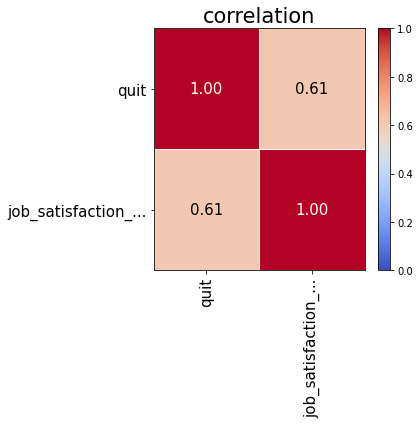

In [67]:
interval_cols = ['job_satisfaction_rate']
corr_matrix_task = phik_matrix(data_task, interval_cols=interval_cols)

plot_correlation_matrix(
    corr_matrix_task.values,
    x_labels=corr_matrix_task.columns,
    y_labels=corr_matrix_task.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation',
    fontsize_factor=1.5,
    figsize=(6, 6)
)

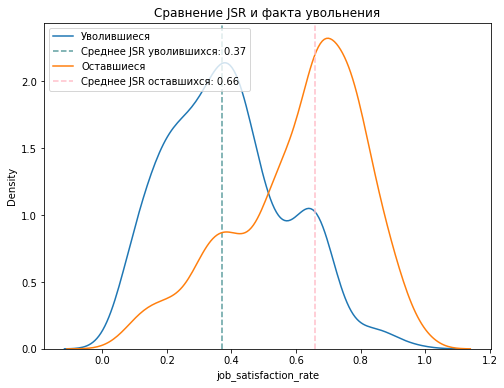

In [68]:
fig, axes = plt.subplots(figsize=(8, 6))

# График №1
sns.kdeplot(
    data=data_task_1,
    label='Уволившиеся',
    ax=axes
)

# Медиана для графика №1
mean_resigned = data_task_1.median()
axes.axvline(
    mean_resigned,
    color='cadetblue',
    linestyle='--',
    label=f'Среднее JSR уволившихся: {mean_resigned:.2f}'
)

# График №2
sns.kdeplot(
    data=data_task_2,
    label='Оставшиеся',
    ax=axes
)

# Медиана для графика №2
mean_not_resigned = data_task_2.median()
axes.axvline(
    mean_not_resigned,
    color='pink', linestyle='--',
    label=f'Среднее JSR оставшихся: {mean_not_resigned:.2f}'
)

axes.set_title('Сравнение JSR и факта увольнения')
plt.legend(loc='upper left')
plt.show()

Согласно данной матрице, действительно имеется корреляция между уровнем удовлетворенности сотрудника и целевым признаком - вероятностью уволиться.

**Вывод по гистограмме:**
Как видно из графика, чем выше уровень удовлетворенности сотрудника, тем меньше вероятность его увольнения. И наоборот, чем ниже уровень удовлетворенности, тем выше риски, что сотрудник покинет компанию.

Поэтому данный признак будет добавлен в тренировочную и тестовую выборки

**Выводы по исследовательскому анализу**
- были изучены ранее не фигурирующие признаки - увольнение. их соотношение в тестовой и тренировочной выборке одинаково

- были изучены признаки датасетов в разрезе целевого признака и на основании полученных данных составлен портрет уволившегося сотрудника
- а также была проверена гипотеза аналитиков, подтвердилось, что есть корреляция между целевыми признаками двух задач, поэтому принято решение добвить уровень удовлетворенности в датасет.


### Добавление нового признака и подготовка данных

Чтобы добавить признак удовлетворенность в тестовую и тренировочную выборки, воспользуемся моделью из предыдущей задачи. Получим предсказания удовлетворенности и добавим в виде дополнительного столбца в тестовую и тренировочную выборки.

In [69]:
#Добавление в тестовую выборку
test_features['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(test_features)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.791880
1,686555,hr,junior,medium,1,no,no,4,30000,0.668205
2,467458,sales,middle,low,5,no,no,4,19200,0.640000
3,418655,sales,middle,low,6,no,no,4,19200,0.640000
4,789145,hr,middle,medium,5,no,no,5,40800,0.744590


In [70]:
train_quit['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(train_quit.drop(['quit'], axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.639885
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.791880
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.376667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.326842
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791880


Признак добавлен, можем переходить к подготовке данных для обучения моделей

При подготовке данных будем масштабировать также и признак - удовлетворенность работой.

А также, так как у нас целевой признак - категориальный, мы будем его кодировать с помощью LabelEncoder.

In [71]:
train_quit = test_features.merge(test_target_quit, on='id').set_index('id')

In [72]:
test_features = test_features.merge(test_target_quit, on='id').set_index('id')
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dept                        2000 non-null   object 
 1   level                       2000 non-null   object 
 2   workload                    2000 non-null   object 
 3   employment_years            2000 non-null   int64  
 4   last_year_promo             2000 non-null   object 
 5   last_year_violations        2000 non-null   object 
 6   supervisor_evaluation       2000 non-null   int64  
 7   salary                      2000 non-null   int64  
 8   job_satisfaction_rate_pred  2000 non-null   float64
 9   quit                        2000 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 171.9+ KB


In [73]:
# Выделим целевой признак и проведем разделение выборки на тренировочную и тестовую. 
# Константы импортировали ранее, поэтому здесь они не фигурируют

X_train_1 = train_quit.drop(['quit'], axis=1)  
y_train_1 = train_quit['quit']                 
X_test_1 = test_features.drop(['quit'], axis=1)
y_test_1 = test_features['quit']
X_train_1.shape


(2000, 9)

In [74]:
le = LabelEncoder()
train_quit['quit'] = le.fit_transform(train_quit['quit'])

# Применяем только transform к тестовой выборке
test_features['quit'] = le.transform(test_features['quit'])

In [75]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred']

Обновим пайплайн.


In [76]:
# Добавим новый признак в preprocessor
num_columns.append('job_satisfaction_rate')

# Обновим модель в итоговом пайплайне
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Обучение моделей:
Целевой признак: Увольнение. 

И перед нами задача бинарной классификации, так как в увольнении может быть только 2 варианта: да или нет.

Зададим параметры для моделей, которые подходят для решения задачи бинарной классификации: модели логистической регрессии, метод опорных векторов, KNN и дерево решений.


In [77]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(6, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf',
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

Будем использовать метод RandomizedSearchCV.

Для оценки качества моделей будем использовать ROC_AUC.

Выбор метрики ROC-AUC для оценки модели является хорошим выбором в данном случае, так как:

- ROC-AUC подходит для задач классификации с неодинаково частыми классами.

- Это метрика, которая хорошо отражает способность модели различать классы.

- ROC-AUC устойчиво к выбросам и может быть полезна даже при наличии нетипичных данных.

In [78]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'midd...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [79]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                              

In [80]:
# Подсчёт ROC-AUC на истинных тестовых данных
y_test_proba_1 = randomized_search.best_estimator_.predict_proba(X_test_1)[:,1]
roc_auc_test = roc_auc_score(y_test_1, y_test_proba_1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_test}')

Метрика ROC-AUC на тестовой выборке: 0.9362801023331161


Результат рассчета метрики ROC-AUC на тестовой выборки 0.94, а на тренировочной 0.92.

Близкое значение на тестовой выборке говорит о том, что модель хорошо обобщается на новых данных и не переобучена.

Однако, так как у нас присутствовал дисбаланс целевого признака, не стоит забывать про то, что он может смещать метрики.

In [81]:
# X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train_1)
# X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test_1)


# explainer = shap.PermutationExplainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, X_test_transformed)
# feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
# explainer.feature_names = feature_names

# # Получение SHAP значений
# shap_values_ = explainer(X_test_transformed)

# # Построение bar графика для SHAP значений
# shap.plots.bar(shap_values_[:,:,1], max_display=16, show=False)

# # Настройка размера шрифта для оси y
# plt.gca().tick_params(axis='y', labelsize=13)
# plt.title('Градация признаков в зависимости от SHAP-значений')
# plt.title('SHAP - Значимость признаков')
# plt.xlabel("Вклад признака")
# plt.ylabel("Признаки")
# plt.show()



In [82]:
# shap.plots.beeswarm(shap_values_[:,:,1], max_display=16, show=False) 
# plt.title('SHAP Beeswarm - Вклад признаков')
# plt.xlabel("Значение")
# plt.ylabel("Признаки")
# plt.show()

Для модели наиболее важным оказался признак количества лет стажа работника. Хотя казалось бы, более очевидным было бы, если бы решение об увольнении зависело бы от признаков с повышением сотрудника, нарушением трудового договора и отделом, зарплатой. 
Но также наличие уровня удовлетворенности всё-таки говорит о том, что этот признак влияет тоже.

Можно предложить один из методов борьбы с "кривыми" значимыми признаками - это удаление их (не брать во внимание при обучении).

### Выводы по задаче №2


На данном шаге исследования была найдена и обучена модель для предсказания того, уволится сотрудник или нет.

Лучшие результаты показала модель SVC(Метод опорных векторов) (random_state=42))])

Также была подсчитана метрика ROC-AUC для модели. Результат получился 0,91 на тестовой выборке и 0,92 на тренировочной. Результат хороший, говорит о том, что модель не переобучена и в принципе правильно может предсказывать.


Этот подход особенно полезен, когда значения целевой переменной могут меняться в большом диапазоне, что применимо к нашему признаку.


А также провели Анализ признаков, которые имеют наибольший вклад в прогноз модели. 

## Общий вывод

**Изучение и предобработка данных**

+ Мы тщательно изучили датасет с тренировочной выборкой, который содержит 4000 записей. В нем были обнаружены пропуски в двух столбцах, что могло быть следствием человеческого фактора или технических проблем. Однако типы данных всех столбцов соответствуют содержащимся в них значениям, поэтому на этапе предобработки данных не потребовалось их переименовывать.

+ Также мы рассмотрели датасет с тестовой выборкой, который состоит из 2000 записей. В нем также были найдены пропуски в двух столбцах, что, возможно, связано с человеческим фактором или техническими неполадками. Типы данных всех столбцов соответствуют данным, поэтому на этапе предобработки мы не стали их переименовывать.

+ Наконец, мы проанализировали датасет с целевым признаком, который содержит 2000 записей. На этот раз пропуски отсутствовали, а типы данных всех столбцов соответствовали содержащимся в них значениям. Описательная статистика не выявила каких-либо выбросов, поэтому на этапе предобработки данных также не потребовалось переименовывать столбцы.

**Анализ пропусков и категориальных признаков**

Поскольку пропуски были обнаружены в столбцах с категориальными признаками, уникальных значений которых было немного, и, вероятно, не существовало закономерностей в их возникновении, мы решили заменить эти значения наиболее распространёнными. Это было сделано с помощью пайплайна.

Кроме того, в процессе предобработки данных мы проверили явные дубликаты, но не обнаружили их ни в одном из датасетов. Однако мы также проверили наличие неявных дубликатов, которые также не были выявлены. Однако в двух датасетах была обнаружена орфографическая ошибка в названии грейда 'senior', которую мы исправили.

**Непрерывные количественные признаки**

Согласно описательной статистике, казалось, что непрерывные количественные признаки были распределены равномерно. Однако при построении графиков мы обнаружили, что это не совсем так: в ежемесячной зарплате сотрудников был сдвиг влево, а уровень удовлетворенности имел небольшой сдвиг вправо. При сравнении с тестовой выборкой мы заметили, что распределение примерно одинаковое, но разный масштаб данных, что свидетельствует о необходимости масштабирования.

**Категориальные признаки**

Анализ графиков позволил нам сделать вывод, что преобладающее количество сотрудников в организации работают меньше одного года или год. Скорее всего, это молодые специалисты, имеющие начальный грейд — Джуниор.

Также мы выяснили, что больше всего сотрудников работают в отделе продаж, а сотрудников с грейдом senior мало, сильно преобладают две другие категории. Это согласуется с выводами, полученными при анализе количественных признаков.

Большинство сотрудников имеют средний уровень загруженности, а повышений в компании практически никто не получал (97%). Возможно, это объясняет преобладание молодых специалистов.

Нарушения трудового договора были выявлены у 14% сотрудников.

Для подготовки категориальных признаков мы использовали кодирование: для повышения и нарушения ТД, отделов — OneHotEncoder, для остальных — OrdinalEncoder.

**Матрица корреляции**

Построив матрицу корреляции, мы сделали вывод, что данные выглядят достоверно, критических выбросов нет, утечки целевого признака также не наблюдается.

**Подготовка данных для обучения**

Обучение будем проводить с подготовкой данных в пайплане. Для признака "Оценка руководителя" высокие значения находятся в правой части графика, что свидетельствует о том, что высокие оценки от руководителя способствуют более высокому уровню удовлетворенности. Признак "Годы работы" имеет смешанный эффект, но можно заметить, что низкие значения (синие) в основном располагаются слева от центра, что указывает на снижение уровня удовлетворенности для сотрудников с меньшим стажем.

**Выводы по задаче №1**

На данном шаге исследования мы нашли и обучили модель для предсказания уровня удовлетворенности сотрудников компании. Лучшие результаты показала модель DecisionTreeRegressor (Дерево решений) с параметрами: max_depth=10 (макс. глубина), max_features=10 (максимальное число признаков), random_state=42.

Выбор модели осуществлялся на основе данных, полученных от метрики SMAPE (Symmetric Mean Absolute Percentage Error). Эта метрика позволяет сравнивать величину ошибки в прогнозировании с фактическими значениями, выражая её в процентах. SMAPE обладает симметричностью, что означает, что она одинаково наказывает за переоценку и недооценку.

Этот подход особенно полезен, когда значения целевой переменной могут изменяться в большом диапазоне, что применимо к нашему признаку.

Метрика SMAPE лучшей модели на тренировочной выборке составила: 17,13, а для тестовой: 10,32. Значение SMAPE на тестовой выборке меньше, чем на тренировочной, что может свидетельствовать о том, что модель лучше справляется с предсказанием на тестовых данных. Кроме того, полученный результат соответствует требованиям проекта (меньше или равно 15).

Мы также провели анализ признаков, которые имеют наибольший вклад в прогноз модели. Получился интересный результат, так как на первом месте должна была оказаться зарплата. Однако топ-5 выглядит следующим образом:

- Оценка руководителя — возможно, для некоторых сотрудников, особенно молодых с небольшим опытом, это может быть мотивацией. Хорошие оценки могут способствовать повышению удовлетворенности, в то время как низкие оценки могут привести к снижению удовлетворенности.

- Годы работы — стаж сотрудников может оказывать влияние на их удовлетворенность.

- Зарплата — уровень дохода сотрудников может играть важную роль в их удовлетворенности.

- Грейд — категория сотрудников может оказывать влияние на их удовлетворенность, особенно в сочетании с другими признаками.

- Были ли нарушения ТД — наличие нарушений трудового договора также может влиять на уровень удовлетворенности сотрудников.

С этим топом можно согласиться, но я бы также предположила, что наличие повышения также имеет влияние.

**Задача №2**

Те же шаги были повторены для задачи №2. Мы изучили датасеты. В этой задаче у нас целевой признак категориальный, и при построении графика был выявлен дисбаланс: значение "Нет" преобладает над значением "Да".

Это может привести к тому, что обученная модель может ошибочно присвоить "Нет" там, где должен быть "Да", что может смещать метрики.

Мы составили портрет сотрудника, который мог бы уволиться или уже уволился:

В отделе, где работает сотрудник, наблюдается высокая текучесть кадров. Если рассматривать абсолютные показатели, то большинство уволившихся сотрудников работали в отделе продаж. Однако если сравнивать относительные показатели, то наибольшее количество увольнений произошло в отделе technology — 29,74 %. В то же время в отделах purchasing, sales и marketing процент уволившихся сотрудников составил от 28 до 29 %.

Уровень занимаемой должности также влияет на текучесть кадров. Больше всего сотрудников увольняется с позиции junior, что вполне логично. Сотрудник приобретает необходимые знания и навыки и переходит на более высокую позицию — middle.

Если рассматривать абсолютные показатели, то количество уволившихся сотрудников с уровнем загруженности medium и low примерно одинаково. Однако если сравнивать относительные показатели, то наибольшее количество увольнений произошло среди сотрудников с уровнем загруженности low — 42,96 %, в то время как среди сотрудников с уровнем загруженности medium этот показатель составил 23,04 %.

Длительность работы в компании также влияет на текучесть кадров. Больше всего сотрудников увольняется в первый год работы — 60,81 %. Во второй и третий год работы этот показатель составляет 37,32 % и 34,03 % соответственно. Доля увольнений среди сотрудников, проработавших в компании более трёх лет, значительно ниже.

Если сотрудник не получал повышения за последний год, то вероятность его увольнения составляет 28,99 %. Среди тех, кто получил повышение, этот показатель ниже — 0,88 %.

Если сотрудник нарушал трудовой договор за последний год, то вероятность его увольнения составляет 41,83 %. Среди тех, кто не нарушал трудовой договор, этот показатель ниже — 26,05 %.


Помимо этого, проанализировав средние заработные платы, мы можем сделать вывод, что у сотрудников, которые уволились, средний доход ниже, чем у тех, кто продолжает работать. Причём это касается всех категорий работников: отделов, уровней загруженности, должностей и оценок работодателя.

Таким образом, типичный уволенный сотрудник — это недавно принятый на работу junior (, который не имеет большой нагрузки, не ценится руководителем и получает низкую заработную плату.

**Исследование корреляции целевых признаков**

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Мы проверили эту гипотезу, добавив в тестовую выборку с целевым признаком Увольнение целевой признак из первой задачи (удовлетворенность работой) и проведя корреляцию между ними. Согласно данной матрице, действительно имеется корреляция между уровнем удовлетворенности сотрудника и целевым признаком — вероятностью уволиться.

Поэтому мы добавили этот признак в тренировочную и тестовую выборки.

Было установлено, что у нас задача классификации, так как в увольнении может быть только два варианта: да или нет.

Мы задали параметры для моделей, которые подходят для решения задачи бинарной классификации: логистической регрессии, метода опорных векторов, KNN и дерева решений.

Для оценки качества моделей использовали ROC-AUC. Выбор этой метрики является хорошим выбором в данном случае, так как:

ROC-AUC подходит для задач классификации с неодинаково частыми классами.

Это метрика, которая хорошо отражает способность модели различать классы.

ROC-AUC устойчива к выбросам и может быть полезна даже при наличии нетипичных данных.

Результат рассчета метрики ROC-AUC на тестовой выборке чуть меньше, чем на тренировочной.

Близкое значение на тестовой выборке говорит о том, что модель хорошо обобщается на новых данных и не переобучена.

Однако, так как у нас присутствовал дисбаланс целевого признака, не стоит забывать о том, что он может смещать метрики.

По значимости признаков можно сделать следующий вывод: для модели наиболее важным оказался признак количества лет стажа работника. Хотя казалось бы, более очевидным было бы, если бы решение об увольнении зависело бы от признаков с повышением сотрудника, нарушением трудового договора и отделом, зарплатой. Но наличие уровня удовлетворенности всё-таки говорит о том, что этот признак влияет тоже.

Можно предложить один из методов борьбы с "кривыми" значимыми признаками — это удаление их (не брать во внимание при обучении).

**Выводы по задаче №2**

На данном шаге исследования мы нашли и обучили модель для предсказания того, уволится сотрудник или нет.

Лучшие результаты показала модель SVC (Метод опорных векторов) с параметрами: random_state=42.

Также была подсчитана метрика ROC-AUC для модели. Результат получился 0,94 на тестовой выборке и 0,92 на тренировочной. 
Результаты оказались положительными, что свидетельствует о том, что модель не была переобучена и в целом способна давать правильные прогнозы.

Этот подход особенно полезен, когда значения целевой переменной могут изменяться в широком диапазоне, что соответствует особенностям нашего признака.

Также мы провели анализ признаков, которые вносят наибольший вклад в прогноз модели.





В числе рекомендаций для заказчика можно выделить следующие: чтобы снизить текучесть кадров, необходимо уделять внимание удовлетворённости сотрудников своей работой. Также следует ускорить процесс их карьерного роста, переводя из категории junior в категорию middle. Кроме того, необходимо обеспечить более высокую загруженность сотрудников, что, в свою очередь, приведёт к увеличению их заработной платы. Наконец, стоит пересмотреть систему оценки работы, поскольку мнение руководителя оказывает значительное влияние на мотивацию сотрудников.

